<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW5_boosting_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**


# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [4]:
import pandas as pd
import requests
from io import StringIO

In [5]:
url = "https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv"
response = requests.get(url)
df = pd.read_csv(StringIO(response.text))

In [6]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

In [16]:
CATEGORICAL_TO_VALUES = {
    'experience_level': ['SE', 'MI', 'EN', 'EX'], 
    'employment_type': ['FT', 'PT', 'CT', 'FL'], 
    'remote_ratio': [0, 50, 100], 
    'company_size': ['S', 'M', 'L']
    }

In [14]:
for col, values in CATEGORICAL_TO_VALUES.items():
    invalid_values = df[~df[col].isin(values)][col]
    if len(invalid_values) > 0:
        print(f'invalid values in column {col}')
        print(invalid_values.unique())


invalid values in column remote_ratio
[100   0  50]


по сути проблем нет, но стоит дополнительно рассмотреть столбец remote_ratio

In [18]:
df['remote_ratio'].unique()
for val in df['remote_ratio'].unique():
    print(f'\'{val}\'')


'100'
'0'
'50'


## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

In [19]:
nan_counts = df.isna().sum()
print(nan_counts)

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64


Пропусков в данных нет

## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

В job_title много категорий.

In [22]:
len(df['job_title'].unique())

93

В salary_currency категорий меньше, но тоже многовато.

In [23]:
len(df['salary_currency'].unique())

20

Достаточно много стран.

In [24]:
len(df['company_location'].unique())

72

кажется, что столбец salary_currency и salary можно удалить, так как у нас есть столбец salary_in_usd (то есть у нас по сути 2 целевых переменных просто в разном формате. если оставить salary, то она сильн будет влиять на таргет)

In [26]:
df = df.drop(['salary', 'salary_currency'], axis=1)

**Ваши выводы здесь**

## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('salary_in_usd', axis=1), df['salary_in_usd'], test_size=0.2, random_state=42)

In [28]:
X_train.head()

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
2238,2022,SE,FT,Data Engineer,ES,0,ES,M
485,2023,MI,FT,Research Scientist,US,100,US,M
2177,2022,SE,FT,Data Analyst,US,0,US,M
3305,2022,SE,FT,Data Engineer,US,100,US,M
1769,2023,SE,FT,Data Engineer,US,100,US,M


## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

In [44]:
CONTINIOUS_FEATURES = ['work_year']
CATEGORICAL_COLUMNS = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']

In [36]:
X_train_c = X_train[CONTINIOUS_FEATURES]
X_test_c = X_test[CONTINIOUS_FEATURES]

## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np


def print_metrics(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse:.2f}")

    mape = mean_absolute_percentage_error(y_test, y_pred) * 100 
    print(f"MAPE: {mape:.2f}%")

In [50]:
from sklearn.linear_model import LogisticRegression

def train_and_test_logreg(X_train, y_train, X_test, y_test):
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    pred = logreg.predict(X_test)

    print_metrics(y_test, pred)

In [51]:
train_and_test_logreg(X_train_c, y_train, X_test_c, y_test)

RMSE: 64454.20
MAPE: 83.62%


Метрики говорят о том, что качество модели очень так себе. модель ошибается в зарплате на более чем 64000%.

## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [52]:
from catboost import CatBoostRegressor

def train_and_test_catboost(X_train, y_train, X_test, y_test):
    catboost = CatBoostRegressor()
    catboost.fit(X_train, y_train)
    pred = catboost.predict(X_test)

    print_metrics(y_test, pred)

In [53]:
train_and_test_catboost(X_train_c, y_train, X_test_c, y_test)

Learning rate set to 0.048714
0:	learn: 62910.8273286	total: 3ms	remaining: 3s
1:	learn: 62746.4106817	total: 3.33ms	remaining: 1.66s
2:	learn: 62597.0032155	total: 3.64ms	remaining: 1.21s
3:	learn: 62490.6476712	total: 3.98ms	remaining: 990ms
4:	learn: 62363.9608720	total: 4.26ms	remaining: 849ms
5:	learn: 62248.9883163	total: 4.55ms	remaining: 754ms
6:	learn: 62169.3535548	total: 4.8ms	remaining: 682ms
7:	learn: 62072.3754102	total: 5.07ms	remaining: 629ms
8:	learn: 62006.3648154	total: 5.3ms	remaining: 584ms
9:	learn: 61924.8474620	total: 5.69ms	remaining: 563ms
10:	learn: 61850.5695609	total: 6.01ms	remaining: 540ms
11:	learn: 61783.2154252	total: 6.32ms	remaining: 520ms
12:	learn: 61722.3560203	total: 6.66ms	remaining: 506ms
13:	learn: 61666.9506606	total: 7.02ms	remaining: 494ms
14:	learn: 61616.7243209	total: 7.35ms	remaining: 483ms
15:	learn: 61571.3222152	total: 7.68ms	remaining: 472ms
16:	learn: 61541.0395505	total: 7.98ms	remaining: 462ms
17:	learn: 61513.6820592	total: 8.3m

Модель лучше чем логистическая регрессия, но качество все равно плохое

## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

In [76]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

X_train_2 = encoder.fit_transform(X_train[CATEGORICAL_COLUMNS])
X_train_2 = pd.DataFrame(X_train_2, columns=encoder.get_feature_names_out(CATEGORICAL_COLUMNS))

X_test_2 = encoder.transform(X_test[CATEGORICAL_COLUMNS])
X_test_2 = pd.DataFrame(X_test_2, columns=encoder.get_feature_names_out(CATEGORICAL_COLUMNS))

X_train_2 = pd.concat([X_train.reset_index(drop=True), X_train_2.reset_index(drop=True)], axis=1)
X_test_2 = pd.concat([X_test.reset_index(drop=True), X_test_2.reset_index(drop=True)], axis=1)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [77]:
X_train_2 = X_train_2.drop(CATEGORICAL_COLUMNS, axis=1)
X_test_2 = X_test_2.drop(CATEGORICAL_COLUMNS, axis=1)

In [79]:
nan_counts = X_train_2.isna().sum()
print(nan_counts)

work_year              0
experience_level_EX    0
experience_level_MI    0
experience_level_SE    0
employment_type_FL     0
                      ..
company_location_UA    0
company_location_US    0
company_location_VN    0
company_size_M         0
company_size_S         0
Length: 235, dtype: int64


In [80]:
train_and_test_logreg(X_train_2, y_train, X_test_2, y_test)

RMSE: 55861.63
MAPE: 47.16%


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [81]:
train_and_test_catboost(X_train_2, y_train, X_test_2, y_test)

Learning rate set to 0.048714
0:	learn: 61996.6298451	total: 4.03ms	remaining: 4.03s
1:	learn: 61004.6405660	total: 5.21ms	remaining: 2.6s
2:	learn: 60078.9203363	total: 6.36ms	remaining: 2.11s
3:	learn: 59234.0716449	total: 7.46ms	remaining: 1.86s
4:	learn: 58549.5884783	total: 8.59ms	remaining: 1.71s
5:	learn: 57828.1397831	total: 9.73ms	remaining: 1.61s
6:	learn: 57144.4503201	total: 10.8ms	remaining: 1.53s
7:	learn: 56524.0987194	total: 12ms	remaining: 1.49s
8:	learn: 56009.3472998	total: 13.2ms	remaining: 1.46s
9:	learn: 55519.8445694	total: 14.4ms	remaining: 1.42s
10:	learn: 55085.9878034	total: 15.5ms	remaining: 1.39s
11:	learn: 54648.8186766	total: 16.6ms	remaining: 1.37s
12:	learn: 54231.8301752	total: 17.7ms	remaining: 1.34s
13:	learn: 53836.7621361	total: 18.9ms	remaining: 1.33s
14:	learn: 53560.5876291	total: 20ms	remaining: 1.31s
15:	learn: 53216.0324997	total: 21.1ms	remaining: 1.3s
16:	learn: 52901.0261346	total: 22.3ms	remaining: 1.29s
17:	learn: 52615.9049371	total: 23

Вывод

Вместо labelEncoder буду использвать OrdinalEncoder, потому что он позволяет закодировать сразу несколько признаков и у него есть поддержка кодирования новых значений, что удобно при кодировании сначала тренировочной, а потом тестовой выборки. labelEncoder и OrdinalEncoder используют одинаковые алгоритмы кодирования, поэтому использование OrdinalEncoder выглядит целесообразно.

In [86]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train_3 = X_train
X_test_3 = X_test

X_train_3[CATEGORICAL_COLUMNS] = ordinal_encoder.fit_transform(X_train_3[CATEGORICAL_COLUMNS])
X_test_3[CATEGORICAL_COLUMNS] = ordinal_encoder.transform(X_test_3[CATEGORICAL_COLUMNS])

In [87]:
train_and_test_logreg(X_train_3, y_train, X_test_3, y_test)

RMSE: 84927.34
MAPE: 55.16%


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [89]:
train_and_test_catboost(X_train_3, y_train, X_test_3, y_test)

Learning rate set to 0.048714
0:	learn: 62147.4929236	total: 1.53ms	remaining: 1.53s
1:	learn: 61190.4089808	total: 2.15ms	remaining: 1.07s
2:	learn: 60386.1643355	total: 3.46ms	remaining: 1.15s
3:	learn: 59640.4013429	total: 4.07ms	remaining: 1.01s
4:	learn: 59025.8863730	total: 4.66ms	remaining: 928ms
5:	learn: 58417.8659958	total: 5.36ms	remaining: 888ms
6:	learn: 57787.6822832	total: 5.95ms	remaining: 843ms
7:	learn: 57208.5687025	total: 6.51ms	remaining: 808ms
8:	learn: 56650.1817306	total: 7.1ms	remaining: 782ms
9:	learn: 56154.6841942	total: 7.67ms	remaining: 759ms
10:	learn: 55621.0895921	total: 8.28ms	remaining: 745ms
11:	learn: 55245.9047119	total: 8.86ms	remaining: 729ms
12:	learn: 54862.5398121	total: 9.44ms	remaining: 717ms
13:	learn: 54496.4956374	total: 10.1ms	remaining: 708ms
14:	learn: 54132.6624728	total: 10.6ms	remaining: 698ms
15:	learn: 53733.0369539	total: 11.3ms	remaining: 693ms
16:	learn: 53421.3162602	total: 11.8ms	remaining: 684ms
17:	learn: 53096.6243448	tota

Вывод

In [ ]:
from sklearn.preprocessing import TargetEncoder

target_encoder = TargetEncoder

## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [ ]:
# Ваш код здесь

**Ваш ответ здесь**.

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

In [ ]:
# Ваш код здесь

**Ваш ответ здесь**.

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [ ]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [ ]:
# Ваш код здесь
X =
y =

In [ ]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [ ]:
# Ваш код здесь
scaler =
X_scaled =

### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [ ]:
# Ваш код здесь
pca =
X_pca =

### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

In [ ]:
# Ваш код здесь
plt.scatter()

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [ ]:
# Ваш код здесь

### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

In [ ]:
# Ваш код здесь

### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

In [ ]:
# Ваш код здесь

**Ваш вывод здесь**

### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [ ]:
# Ваш код здесь

**Ваш вывод здесь**

### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

**Ваш вывод здесь**

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

In [ ]:
from PIL import Image
# or
#import cv2

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [ ]:
def find_components(image, lmbd, n_clusters):
    #your code here

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

In [ ]:
def spectral_segmentation(image, n_clusters, beta, eps):
    #your code here

### **(0.1 балл)**
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный котобонус :)

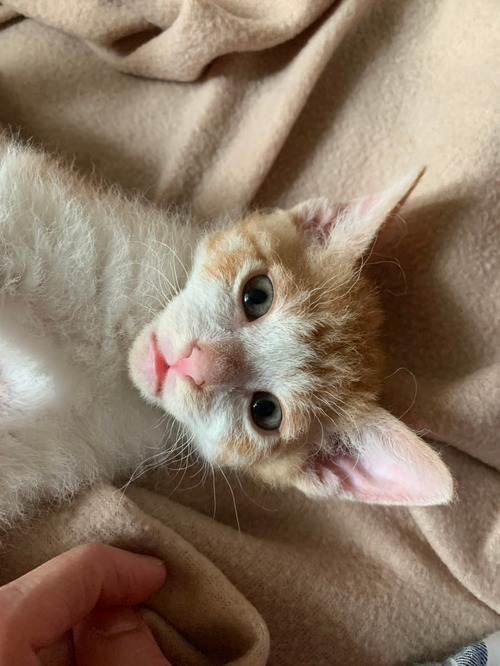